In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import textwrap
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import sem
from seaborn.algorithms import bootstrap
from seaborn import utils
import pingouin as pg
from scipy.stats import wilcoxon
import matplotlib.dates as mdates
def ci_func(x):
    boots = bootstrap(x, func=np.mean, n_boot=1000,nits=None)
    return utils.ci(boots, 95)[0], utils.ci(boots, 95)[1]


mpl.style.use('toby')

## Get data

In [109]:
group_df = pd.read_csv('../data/all_data_long.csv')
group_df_wide = pd.read_csv('../data/all_data_wide.csv')

In [110]:
follow_up_df_wide = group_df_wide[~group_df_wide['q1_T2'].isnull()]
follow_up_df_wide = follow_up_df_wide.dropna(subset=[i for i in follow_up_df_wide.columns if 'q' in i])
follow_up_df = group_df[group_df['subjectID'].isin(follow_up_df_wide['subjectID'])]
group_df = group_df[group_df['phase'] == 'T1']

## Plot changes over time

C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

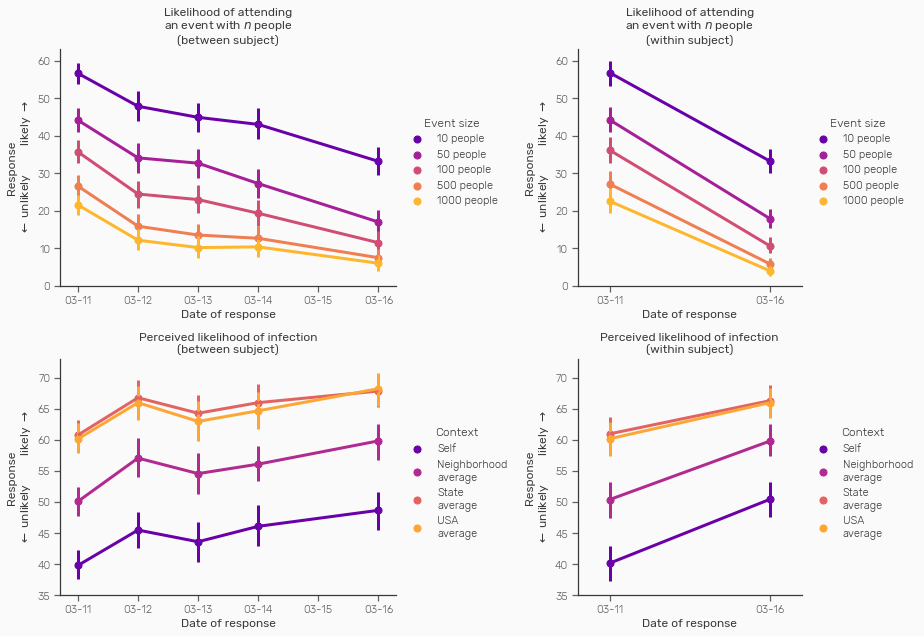

In [152]:
# BETWEEN SUBJECT BEHAVIOUR
q1_df = group_df[group_df['qid'].isin([20, 21, 22, 23, 24])]
q1_df['date'] = pd.to_datetime(q1_df['date'], errors='coerce').dt.normalize()
q1_df['response'] = pd.to_numeric(q1_df['response'])

plot_df = q1_df[(~q1_df['date'].isnull()) & (q1_df['date'] < '11-01-2020')]
plot_df['qid'] = plot_df['qid'].astype(str).replace({'20':'10 people', '21': '50 people', '22': '100 people', '23': '500 people', '24': '1000 people'})
plot_df = plot_df.rename(columns={'qid': 'Event size'})

cmap = mpl.cm.get_cmap('plasma')
hues = cmap(np.arange(0.2, 1, 0.8 / len(plot_df['date'].unique())))

f, ax = plt.subplots(2, 2, figsize=(13, 9), gridspec_kw=dict(width_ratios=[0.6, 0.4]))

for n, cat in enumerate(plot_df['Event size'].unique()):
    temp_df = plot_df[plot_df['Event size'] == cat]
#     m = temp_df['response'].groupby('date').mean()
    ss = temp_df.groupby('date')['response'].agg(lambda x: ci_func(x))
    m = temp_df.groupby('date').mean()['response']
    ax[0, 0].errorbar(sorted(temp_df['date'].unique()), m, yerr=np.abs(np.stack(ss).T - m[np.newaxis, :]), color=hues[n], linewidth=3)
    ax[0, 0].scatter(sorted(temp_df['date'].unique()), m, color=hues[n], s=50, label=cat)
    
ax[0, 0].set_ylabel('Response\n' + r'$\leftarrow$ unlikely          likely $\rightarrow$' )
ax[0, 0].set_xlabel('Date of response')
ax[0, 0].set_title('Likelihood of attending\n' + r'an event with $n$ people' + '\n(between subject)')
ax[0, 0].legend(bbox_to_anchor=(1, 0.75), title='Event size', frameon=False)
ax[0, 0].set_ylim(0, 63)
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

## WITHIN SUBJECT BEHAVIOUR
hues = cmap(np.arange(0.2, 1, 0.8 / len(temp_df['date'].unique())))

qs = ['q20', 'q21', 'q22', 'q23', 'q24']

for n, cat in enumerate(plot_df['Event size'].unique()):
    ss = np.vstack([ci_func(follow_up_df_wide[qs[n]]), ci_func(follow_up_df_wide[qs[n] + '_T2'])])
    m = np.hstack([follow_up_df_wide[qs[n]].mean(), follow_up_df_wide[qs[n] + '_T2'].mean()])
    ax[0, 1].errorbar(range(2), m, yerr=np.abs(np.stack(ss).T - m[np.newaxis, :]), color=hues[n], linewidth=3)
    ax[0, 1].scatter(range(2), m, color=hues[n], s=50, label=cat)

ax[0, 1].set_xticks(range(2))
ax[0, 1].set_xticklabels(['03-11', '03-16'])
ax[0, 1].set_xlim(-0.2, 1.2)
ax[0, 1].set_ylabel('Response\n' + r'$\leftarrow$ unlikely          likely $\rightarrow$' )
ax[0, 1].set_xlabel('Date of response')
ax[0, 1].set_title('Likelihood of attending\n' + r'an event with $n$ people' + '\n(within subject)')
ax[0, 1].legend(bbox_to_anchor=(1, 0.75), title='Event size', frameon=False)
ax[0, 1].set_ylim(0, 63)


# BETWEEN SUBJECT RISK
q1_df = group_df[group_df['qid'].isin([1, 6, 7, 8])]
q1_df['date'] = pd.to_datetime(q1_df['date'], errors='coerce').dt.normalize()
q1_df['response'] = pd.to_numeric(q1_df['response'])

plot_df = q1_df[(~q1_df['date'].isnull()) & (q1_df['date'] < '11-01-2020')]
plot_df['qid'] = plot_df['qid'].astype(str).replace({'1':'Self', '6': 'Neighborhood\naverage', '7': 'State\naverage', '8': 'USA\naverage'})
plot_df = plot_df.rename(columns={'qid': 'Perceived likelihood'})

hues = cmap(np.arange(0.2, 1, 0.8 / len(plot_df['Perceived likelihood'].unique())))

for n, cat in enumerate(plot_df['Perceived likelihood'].unique()):
    temp_df = plot_df[plot_df['Perceived likelihood'] == cat]
#     m = temp_df['response'].groupby('date').mean()
    ss = temp_df.groupby('date')['response'].agg(lambda x: ci_func(x))
    m = temp_df.groupby('date').mean()['response']
    ax[1, 0].errorbar(sorted(temp_df['date'].unique()), m, yerr=np.abs(np.stack(ss).T - m[np.newaxis, :]), color=hues[n], linewidth=3)
    ax[1, 0].scatter(sorted(temp_df['date'].unique()), m, color=hues[n], s=50, label=cat)
    
ax[1, 0].set_ylabel('Response\n' + r'$\leftarrow$ unlikely          likely $\rightarrow$' )
ax[1, 0].set_xlabel('Date of response')
ax[1, 0].set_title('Perceived likelihood of infection\n(between subject)')
ax[1, 0].legend(bbox_to_anchor=(1, 0.75), title='Context', frameon=False)
ax[1, 0].set_ylim(35, 73)
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

## WITHIN SUBJECT BEHAVIOUR
qs = ['q1', 'q6', 'q7', 'q8']

for n, cat in enumerate(plot_df['Perceived likelihood'].unique()):
    ss = np.vstack([ci_func(follow_up_df_wide[qs[n]]), ci_func(follow_up_df_wide[qs[n] + '_T2'])])
    m = np.hstack([follow_up_df_wide[qs[n]].mean(), follow_up_df_wide[qs[n] + '_T2'].mean()])
    ax[1, 1].errorbar(range(2), m, yerr=np.abs(np.stack(ss).T - m[np.newaxis, :]), color=hues[n], linewidth=3)
    ax[1, 1].scatter(range(2), m, color=hues[n], s=50, label=cat)

ax[1, 1].set_xticks(range(2))
ax[1, 1].set_xticklabels(['03-11', '03-16'])
ax[1, 1].set_xlim(-0.2, 1.2)
ax[1, 1].set_ylabel('Response\n' + r'$\leftarrow$ unlikely          likely $\rightarrow$' )
ax[1, 1].set_xlabel('Date of response')
ax[1, 1].set_title('Perceived likelihood of infection\n(within subject)')
ax[1, 1].legend(bbox_to_anchor=(1, 0.75), title='Context', frameon=False)
ax[1, 1].set_ylim(35, 73)

sns.despine()

plt.tight_layout()

plt.savefig('../figures/changes_over_time.png', dpi=200)
plt.savefig('../figures/changes_over_time.svg')

# Stats

### ANOVAs

### Between subjects effects

#### Create some useful dataframes

In [112]:
behaviour_between_df = group_df[group_df['qid'].isin([20, 21, 22, 23, 24])]
behaviour_between_df['date'] = pd.to_datetime(behaviour_between_df['date'], errors='coerce').dt.normalize()
behaviour_between_df['response'] = pd.to_numeric(behaviour_between_df['response'])
behaviour_between_df = behaviour_between_df[['subjectID', 'date', 'qid', 'response']]

risk_between_df = group_df[group_df['qid'].isin([1, 6, 7, 8])]
risk_between_df['date'] = pd.to_datetime(risk_between_df['date'], errors='coerce').dt.normalize()
risk_between_df['response'] = pd.to_numeric(risk_between_df['response'])
risk_between_df = risk_between_df[['subjectID', 'date', 'qid', 'response']]

C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [113]:
behaviour_between_df = pd.melt(behaviour_between_df, ['subjectID', 'qid', 'date'])
risk_between_df = pd.melt(risk_between_df, ['subjectID', 'qid', 'date'])

#### Behaviour - avoidance of crowds

In [114]:
aov = pg.mixed_anova(dv='value', between='date', within='qid', subject='subjectID', data=behaviour_between_df)
pg.print_table(aov)


ANOVA SUMMARY

Source                SS    DF1    DF2          MS         F    p-unc  p-GG-corr      np2  eps    sphericity    W-spher    p-spher
-----------  -----------  -----  -----  ----------  --------  -------  -----------  -----  -----  ------------  ---------  ---------
date          495479.941      6   1579   82579.990    22.839    0.000  -            0.080  -      -             -          -
qid          1135935.362      4   6316  283983.841  1311.681    0.000  0.0          0.454  0.452  False         0.046      0.0
Interaction    23243.100     24   6316     968.463     4.473    0.000  -            0.017  -      -             -          -



#### Risk perception - likelihood of infection

In [115]:
aov = pg.mixed_anova(dv='value', between='date', within='qid', subject='subjectID', data=risk_between_df)
pg.print_table(aov)


ANOVA SUMMARY

Source               SS    DF1    DF2          MS        F    p-unc  p-GG-corr                 np2  eps    sphericity    W-spher    p-spher
-----------  ----------  -----  -----  ----------  -------  -------  ----------------------  -----  -----  ------------  ---------  ----------------------
date          74544.774      6   1579   12424.129    6.475    0.000  -                       0.024  -      -             -          -
qid          436028.132      3   4737  145342.711  579.003    0.000  6.223710488498973e-246  0.268  0.762  False         0.625      7.962399893542529e-159
Interaction    1652.912     18   4737      91.828    0.366    0.993  -                       0.001  -      -             -          -



### Within subject effects

#### Create some dataframes

In [116]:
behaviour_within_df = follow_up_df[follow_up_df['qid'].isin([20, 21, 22, 23, 24])]
risk_within_df = follow_up_df[follow_up_df['qid'].isin([1, 6, 7, 8])]

In [117]:
aov = pg.rm_anova(dv='response', within=['qid', 'phase'], subject='subjectID', data=behaviour_within_df)
pg.print_table(aov)


ANOVA SUMMARY

Source               SS    ddof1    ddof2          MS        F    p-unc    p-GG-corr    np2    eps
-----------  ----------  -------  -------  ----------  -------  -------  -----------  -----  -----
qid          485080.391        4     1496  121270.098  517.510    0.000        0.000  0.580  0.408
phase        498055.757        1      374  498055.757  279.024    0.000        0.000  0.427  1.000
qid * phase    7518.604        4     1496    1879.651   10.738    0.000        0.001  0.028  0.250



In [118]:
aov = pg.rm_anova(dv='response', within=['qid', 'phase'], subject='subjectID', data=risk_within_df)
pg.print_table(aov)


ANOVA SUMMARY

Source               SS    ddof1    ddof2         MS        F    p-unc    p-GG-corr    np2    eps
-----------  ----------  -------  -------  ---------  -------  -------  -----------  -----  -----
qid          165845.457        3     1122  55281.819  173.854    0.000        0.000  0.317  0.723
phase         44475.200        1      374  44475.200   69.194    0.000        0.000  0.156  1.000
qid * phase    3510.412        3     1122   1170.137    7.564    0.000        0.006  0.020  0.333



## Hand-washing and distancing over time

In [119]:
t1_scores = follow_up_df.loc[(follow_up_df['qid'] == 29) & (follow_up_df['phase'] == 'T1'), 'response']
t2_scores = follow_up_df.loc[(follow_up_df['qid'] == 29) & (follow_up_df['phase'] == 'T2'), 'response']
t, p = wilcoxon(t1_scores, t2_scores)
print('Hand washing - W({0}) = {1}, p = {2}\nMedian T1 = {3}, median T2 = {4}'.format(len(t1_scores), 
                                                                                      np.round(t, 2), np.round(p, 4), np.median(t1_scores), np.median(t2_scores)))

t1_scores = follow_up_df.loc[(follow_up_df['qid'] == 30) & (follow_up_df['phase'] == 'T1'), 'response']
t2_scores = follow_up_df.loc[(follow_up_df['qid'] == 30) & (follow_up_df['phase'] == 'T2'), 'response']
t, p = wilcoxon(t1_scores, t2_scores)
print('Social distancing - W({0}) = {1}, p = {2}\nMedian T1 = {3}, median T2 = {4}'.format(len(t1_scores), 
                                                                                      np.round(t, 2), np.round(p, 4), np.median(t1_scores), np.median(t2_scores)))

Hand washing - W(375) = 25027.5, p = 0.0007
Median T1 = 71.0, median T2 = 78.0
Social distancing - W(375) = 12269.0, p = 0.0
Median T1 = 48.0, median T2 = 79.0
